In [262]:
import os
import requests
from bs4 import BeautifulSoup
import pandas as pd
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import time
import numpy as np

from pandas import ExcelWriter
from datetime import datetime, date, timedelta
import matplotlib as mpl
import matplotlib.ticker as mtick
import dateutil
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rcParams
import seaborn as sns
import locale
from pandas import ExcelWriter
import sklearn
from sklearn.linear_model import LinearRegression

In [151]:
def _initialize_driver():
    options = webdriver.ChromeOptions()
    options.add_argument('--ignore-certificate-errors')
    options.add_argument('--ignore-ssl-errors')

    prefs = {
        "profile.default_content_settings.popups": 0,
        "download.prompt_for_download": False,
        "download.directory_upgrade": True,
        "safebrowsing.enabled": True,
        'extensions.disabled': True,
    }
    options.add_experimental_option("prefs", prefs)
    driver_loc = os.path.join(os.getcwd(),"chromedriver")
    while True:
        try:
            driver = webdriver.Chrome(driver_loc, chrome_options=options)
            break
        except:
            pass
    return driver

In [263]:
sns.set(style='ticks')
# pal = sns.color_palette([
#     [31 / 255, 73 / 255, 125 / 255], #JPMBlue
#     [247 / 255, 150 / 255, 70 / 255], #JPMOrange
#     [155 / 255, 187 / 255, 89 / 255] #JPMGreen
# ])

pal = sns.color_palette([
    [222 / 255, 110 / 255, 116 / 255], #JPMBlue
    [101 / 255, 134 / 255, 194 / 255], #JPMOrange
    [43 / 255, 175 / 255, 100 / 255] #JPMGreen
])

linestyles = [
    {'c': pal[0], 'linestyle': '-'}, 
    {'c': pal[1], 'linestyle': '-'}, 
    {'c': pal[0], 'linestyle': 'dashed'}, 
    {'c': pal[1], 'linestyle': 'dashed'}, 
    {'c': pal[0], 'linestyle': ':'}, 
    {'c': pal[1], 'linestyle': ':'}, 
    {'c': pal[2], 'linestyle': '-'}, 
    {'c': pal[2], 'linestyle': 'dashed'}, 
    {'c': pal[2], 'linestyle': ':'}, 
    
]

barstyles = [
    {'color': pal[0], },
    {'color': pal[0], },
    {'edgecolor': pal[0], 'color': 'white', 'linewidth': 1, 'hatch': '////'},
    {'edgecolor': pal[1], 'color': 'white', 'linewidth': 1, 'hatch': '////'},
    {'edgecolor': pal[0], 'color': 'white', 'linewidth': 1, 'hatch': '....'},
    {'edgecolor': pal[1], 'color': 'white', 'linewidth': 1, 'hatch': '....'},
    
]

rcParams = {
    'font.family' : 'sans-serif',
    'font.sans-serif' : 'Arial',
    'font.weight' : 'bold',
    'font.stretch' : 'condensed',
    'figure.autolayout' : False,
    'hatch.linewidth' : 0.2
}

csfont = {'fontname':'Comic Sans MS'}
hfont = {'fontname':'Helvetica'}
# Plantagenet Cherokee

# CHARTDIR
SAVEFIG_KWARGS = {'dpi': 72*4}
LEGEND_KWARGS = {'frameon': True, 'framealpha': 0.9, 'labelspacing': 0.4}
CHART_GAP = timedelta(days=20)
CHART_TITLE_ALIGN = 'left'

# yearsFmt = mdates.DateFormatter('%b-%Y')
# yearsFmt = mdates.DateFormatter('%b-%d')
# yearsFmt = mdates.DateFormatter('%Y')
fontsize = 15
fontweight = 'regular'
title_fontsize = 15
title_fontweight = 'regular'
tick_label_size = 15
tick_label_weight = 'regular'
legend_title_fontsize = 15
legend_title_fontweight = 'regular'
legend_label_fontsize = 15
legend_label_fontweight = 'regular'

annotation_fontsize = 15
annotation_fontweight = 'regular'
xticks_params = {
    'pad' : 1,
    'length' : 3,
}
yticks_params = {
    'pad' : 2,
    'length' : 2,
}

savefig_params = {
    'bbox_inches' : 'tight',
    'pad_inches' : 0.4,
}
xlabel_params = {
    'position' : (0.5,0.5),
    'fontsize' : 15,
    'fontweight' : 'regular',
    'labelpad': None,
}
ylabel_params = {
    'fontsize' : 15,
    'fontweight' : 'regular',
}


footnote_fontsize = 15
footnote_fontweight = 'regular'
fontname = "Baskerville"
def apply_to_axes(axes, footnote_text = 'AllStuffData'):
    _axes = (axes,) if not isinstance(axes, tuple) else axes
    for ax in axes:
        ax.xaxis.label.set_fontsize(xlabel_params['fontsize'])
        ax.yaxis.label.set_fontsize(ylabel_params['fontsize'])
        for item in [ax.xaxis.label, ax.yaxis.label]:
            item.set_fontweight(fontweight)
            item.set_fontname(fontname)
        
        ax.title.set_fontsize(title_fontsize)
        ax.title.set_fontweight(title_fontweight)
        ax.title.set_fontname(fontname)
        
        for item in ax.get_xticklabels() + ax.get_yticklabels():
            item.set_fontsize(tick_label_size)
            item.set_fontweight(tick_label_weight)
            item.set_fontname(fontname)
            
        if ax.get_legend() is not None:
            lt = ax.get_legend().get_title()
            lt.set_fontsize(legend_title_fontsize)
            lt.set_fontweight(legend_title_fontweight)
            lt.set_fontname(fontname)
            t0 = ax.get_legend().get_texts()[0]
            t0.set_fontsize(legend_label_fontsize)
            t0.set_fontweight(legend_label_fontweight)
            t0.set_fontname(fontname)
        
        footnote = ax.annotate(footnote_text, **footnote_params)
        footnote.set_fontsize(footnote_fontsize)
        footnote.set_fontname(fontname)
        footnote.set_fontweight(footnote_fontweight)
        
    return axes

In [83]:
def get_result_india_score(link):
    url = "http://www.howstat.com/cricket/statistics"+link[2:]
    res = requests.get(url)
    soup = BeautifulSoup(res.content,"lxml")
    table = soup.find_all("table")
    fin_table = table[5]
    rows =  fin_table.find_all("tr")
    for i,item in enumerate(rows):
        for j,thing in enumerate(item.find_all("td")):
            if thing.text.strip() == "Result:":
                try:
                    result = item.find_all("td")[j+1].text.strip()
                except:
                    pass
            if "India" in thing.text.strip():
                try:
                    if rows[i+13].find_all("td")[0].text.strip() == "Total":
                        score = rows[i+13].find_all("td")[2].text.strip()
                except:
                    score = np.nan
                    pass
    return result,score

In [144]:
players=[
    ['http://www.howstat.com/cricket/Statistics/Players/PlayerProgressBat_ODI.asp?PlayerID=3600', 'Kohli'],
    ['http://www.howstat.com/cricket/Statistics/Players/PlayerProgressBat_ODI.asp?PlayerID=3474', 'Sharma'],
    ['http://www.howstat.com/cricket/Statistics/Players/PlayerProgressBat_ODI.asp?PlayerID=3243', 'Dhoni'],
    ['http://www.howstat.com/cricket/Statistics/Players/PlayerProgressBat_ODI.asp?PlayerID=2949', 'Yuvraj'],
    ['http://www.howstat.com/cricket/Statistics/Players/PlayerProgressBat_ODI.asp?PlayerID=1735', 'Sachin'],
    ['http://www.howstat.com/cricket/Statistics/Players/PlayerProgressBat_ODI.asp?PlayerID=2878', 'Sehwag'],
    ['http://www.howstat.com/cricket/Statistics/Players/PlayerProgressBat_ODI.asp?PlayerID=2060', 'Dravid'],
    ['http://www.howstat.com/cricket/Statistics/Players/PlayerProgressBat_ODI.asp?PlayerID=2059', 'Ganguly'],
]

In [107]:
for item in players:
    url = item[0]
    file_name = item[1]+".pkl"
    res = requests.get(url)
    soup = BeautifulSoup(res.content,"lxml")
    table = soup.find("table", {"class": "TableLined"})
    rows =  table.find_all("tr")
    total_list=[]
    for item in rows:
        row_list = []
        for thing in item.find_all("td"):
            row_list.append(thing.text.replace('\n','').replace('\r','').replace('\t',''))
            try:
                row_list.append(thing.find('a', href=True)['href'])
                result, score = get_result_india_score(thing.find('a', href=True)['href'])
                row_list.append(result)
                row_list.append(score)
            except:
                pass
        total_list.append(row_list)
    df = pd.DataFrame(total_list)
    df = df[3:-1]
    df.columns = [
        'SNo','Date', 'MatchLink', 'Result','Indias_score','Versus','Ground','D/N','How Dismissed','Runs','B/F','S/R','Blank','Aggr','Avg','Cumulative S/R'
    ]
    df.to_pickle(file_name)

In [141]:
# df

In [132]:
def save_xls(list_dfs, xls_path):
    with ExcelWriter(xls_path) as writer:
        for n, df in enumerate(list_dfs):
            df.to_excel(writer,'sheet%s' % n)
        writer.save()

In [138]:
xls_path = "Cricket_processed.xlsx"

In [145]:
with ExcelWriter(xls_path) as writer:
    for item in players:
        file_name = item[1]+".pkl"
        df = pd.read_pickle(file_name)
        df.MatchLink = "http://www.howstat.com/cricket/statistics"+df.MatchLink.str[2:]
#         url = "http://www.howstat.com/cricket/statistics"+link[2:]
        for i,row in df.iterrows():
            res = ""
            if row['Result'].find('won') > -1:
                res = (row['Result'][:row['Result'].find('won')].strip())
            else:
                if "tied" in row['Result']:
                    res = "Tied"
                else:
                    res = "NA"
            df.loc[i,'Result_win'] = res
            if res == "India":
                df.loc[i,'Result_num'] = 1
            elif res == "Tied":
                df.loc[i,'Result_num'] = 0
            elif res == "NA":
                df.loc[i,'Result_num'] = np.nan
            else:
                df.loc[i,'Result_num'] = -1

        try:
            df['Runs'] = df['Runs'].str.replace("*","").str.strip()
            df['Runs'] = df['Runs'].replace('-', np.nan)
            df['Runs'] = df['Runs'].astype(float)
            df['Indias_score'] = df['Indias_score'].str.replace("*","").str.strip()
            df['Indias_score'] = df['Indias_score'].replace('-', np.nan)
            df['Indias_score'] = df['Indias_score'].astype(float)
        except:
            pass
        df.to_excel(writer,item[1])
    writer.save()

In [148]:
# df.head()

In [150]:
xls_path = "India_win.xlsx"
dfs = []
with ExcelWriter(xls_path) as writer:
    for item in players:
        file_name = item[1]+".pkl"
        df = pd.read_pickle(file_name)
        df.MatchLink = "http://www.howstat.com/cricket/statistics"+df.MatchLink.str[2:]
#         url = "http://www.howstat.com/cricket/statistics"+link[2:]
        for i,row in df.iterrows():
            res = ""
            if row['Result'].find('won') > -1:
                res = (row['Result'][:row['Result'].find('won')].strip())
            else:
                if "tied" in row['Result']:
                    res = "Tied"
                else:
                    res = "NA"
            df.loc[i,'Result_win'] = res
            if res == "India":
                df.loc[i,'Result_num'] = 1
            elif res == "Tied":
                df.loc[i,'Result_num'] = 0
            elif res == "NA":
                df.loc[i,'Result_num'] = np.nan
            else:
                df.loc[i,'Result_num'] = -1

        try:
            df['Runs'] = df['Runs'].str.replace("*","").str.strip()
            df['Runs'] = df['Runs'].replace('-', np.nan)
            df['Runs'] = df['Runs'].astype(float)
            df['Indias_score'] = df['Indias_score'].str.replace("*","").str.strip()
            df['Indias_score'] = df['Indias_score'].replace('-', np.nan)
            df['Indias_score'] = df['Indias_score'].astype(float)
        except:
            pass
        df = df[df.Result_num == 1]
        df = df[['MatchLink','Indias_score','Runs','Result_num']]
        df.Result_num = item[1]
        dfs.append(df)
        df.to_excel(writer,item[1])
    writer.save()

In [134]:
# df = df[['Indias_score','Runs','Result_num']]

In [135]:
pd.set_option('display.max_rows', 1000)

In [173]:
driver = _initialize_driver()

/Users/gopal/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: use options instead of chrome_options


In [174]:
team1 = "/html/body/form/table/tbody/tr[2]/td[3]/table[2]/tbody/tr/td[1]/table[2]/tbody/tr[1]/td[1]"
team2 = "/html/body/form/table/tbody/tr[2]/td[3]/table[2]/tbody/tr/td[1]/table[2]/tbody/tr[20]/td[1]"
score1 = "/html/body/form/table/tbody/tr[2]/td[3]/table[2]/tbody/tr/td[1]/table[2]/tbody/tr[14]/td[3]"
score2 = "/html/body/form/table/tbody/tr[2]/td[3]/table[2]/tbody/tr/td[1]/table[2]/tbody/tr[33]/td[3]"

In [175]:
def find_india_score(link):
    url = link
    driver.get(url)
    elem1 = WebDriverWait(driver, 5).until(EC.presence_of_element_located((By.XPATH, team1))).text
    elem1_ = WebDriverWait(driver, 5).until(EC.presence_of_element_located((By.XPATH, score1))).text
    elem2 = WebDriverWait(driver, 5).until(EC.presence_of_element_located((By.XPATH, team2))).text
    elem2_ = WebDriverWait(driver, 5).until(EC.presence_of_element_located((By.XPATH, score2))).text
    if "India" in elem1:
        score = elem1_
    elif "India" in elem2:
        score =  elem2_
    else:
        score = np.nan
        print(url)
    print(score)
    return score

In [192]:
# for j,df in enumerate(dfs):
#     for i,row in df.iterrows():
#         if str(row['Indias_score']).strip() == "nan":
#             score = find_india_score(row['MatchLink'])
#             df.loc[i,'Indias_score'] = score
#     dfs[j] = df
#     print("DF Ends")
dfs[0].head()


,MatchLink,Indias_score,Runs,Result_num,Perc
4,http://www.howstat.com/cricket/statistics/Matc...,143,37.0,Kohli,0.258741
5,http://www.howstat.com/cricket/statistics/Matc...,237,25.0,Kohli,0.105485
6,http://www.howstat.com/cricket/statistics/Matc...,258,54.0,Kohli,0.209302
8,http://www.howstat.com/cricket/statistics/Matc...,319,2.0,Kohli,0.006270
11,http://www.howstat.com/cricket/statistics/Matc...,130,79.0,Kohli,0.607692


In [201]:
df_final = []
for df in dfs:
    try:
        df['Runs'] = df['Runs'].astype(str)
        df['Runs'] = df['Runs'].str.replace("*","").str.strip()
        df['Runs'] = df['Runs'].replace('-', np.nan)
        df['Runs'] = df['Runs'].astype(float)
        df['Indias_score'] = df['Indias_score'].astype(str)
        df['Indias_score'] = df['Indias_score'].str.replace("*","").str.strip()
        df['Indias_score'] = df['Indias_score'].replace('-', np.nan)
        df['Indias_score'] = df['Indias_score'].astype(float)
    except:
        pass
    df['Perc'] = (df.Runs.astype(float))/(df.Indias_score.astype(float))
    name = list(df.Result_num.unique())[0]
    df = df[['Perc']]
    df.columns = [name]
    df = df.dropna()
    df = df.reset_index()
    
    df_final.append(df)

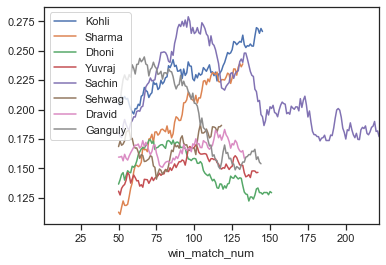

In [229]:
df = pd.concat(df_final, axis=1)
df = df[[ 'Kohli','Sharma', 'Dhoni', 'Yuvraj', 'Sachin', 'Sehwag',  'Dravid','Ganguly']]
df['win_match_num'] = np.arange(len(df))+1
df = df.set_index('win_match_num')
df = df.rolling(window=50).mean()
df.plot.line()

In [271]:
# x_min = datetime(2013,3,1)
# x_max = date.today() + timedelta(100)
# tickrule = dateutil.rrule.rrule(
#     freq = dateutil.rrule.DAILY,
#     interval = 366,
#     dtstart = x_min,
#     until = x_max,
# )
pal = sns.color_palette([
    [0 / 255, 255 / 255, 255 / 255], #Blue
    [255 / 255, 255 / 255, 102 / 255], #Yellow
    [255 / 255, 80 / 255, 80 / 255], #Red
    [255 / 255, 153 / 255, 102 / 255] #Orange
])
# yearsFmt = mdates.DateFormatter('%Y')
footnote_params = {
    'xy': (0,-0.17),
    'xycoords':'axes fraction',
    'xytext': (0,-24),
    'textcoords': 'offset points',
    'va': 'top',
    
}
legend_placement_kwargs = {
    'loc': 'upper center',
    'bbox_to_anchor': (.5,-0.10),
    'ncol': 4,
}

grid_kwargs = {
    'linestyle': '-',
    'linewidth': 0.2,
#     'color': 3,
}


SAVEFIG_KWARGS = {'dpi': 72*4}

COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rcParams['lines.color'] = COLOR
mpl.rcParams['axes.edgecolor'] = COLOR

In [272]:
df1 = df.copy()
df1 = df1*100

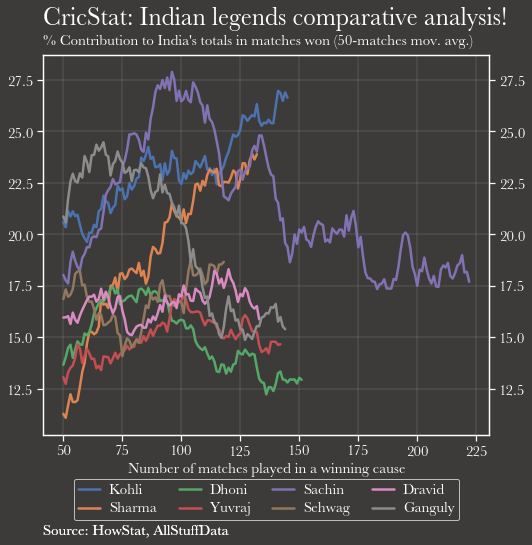

In [282]:

fig, ax = plt.subplots(figsize=(8,7))
for i, item in enumerate(list(df1.columns)):
    df_ = df1[[item]]
    ax.plot(df_.index.values, df_[item], label = item, linewidth=2.5)
    
mpl.rcParams['savefig.facecolor'] = (61.0/255, 58.5/255, 57.0/255)
ax.set_facecolor((61.0/255, 58.5/255, 57.0/255))
fig.patch.set_facecolor((61.0/255, 58.5/255, 57.0/255))


ax.grid(b=None, which='major', axis='both',**grid_kwargs)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())


fig.text(0.125,0.90,"% Contribution to India's totals in matches won (50-matches mov. avg.)",fontdict={'fontsize':15,'fontweight':'regular','fontname':'Baskerville'})
footnote_text = "Source: HowStat, AllStuffData"
ax.set_title('CricStat: Indian legends comparative analysis!', loc=CHART_TITLE_ALIGN, fontdict={'fontsize':25,'fontweight':'bold', 'fontname':'Baskerville'}, pad=30 )
ax.set_xlabel("Number of matches played in a winning cause")
# ax.set_ylabel("Units in %")
ax.legend(**LEGEND_KWARGS,**legend_placement_kwargs,facecolor =(61.0/255, 58.5/255, 57.0/255))
# ax.xaxis.set_major_formatter(yearsFmt)
# ax.get_yaxis().set_major_formatter(formatter_cr)
# ax1.get_yaxis().set_major_formatter(formatter_cr)
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())
apply_to_axes((ax,ax1),footnote_text = footnote_text)

f = os.path.dirname(os.getcwd())+'/todays_chart/cricket_1.jpg'
fig.savefig(f, **SAVEFIG_KWARGS, **savefig_params, transparent = True)